In [5]:
import warnings
warnings.filterwarnings('ignore')


In [6]:
# installing the needed libraries
!pip install nltk --upgrade --quiet
!pip install wordcloud --upgrade --quiet
!pip install plotly  --upgrade --quiet
!pip install statsmodels --upgrade --quiet
!pip install gensim --upgrade --quiet
!pip install nltk --upgrade --quiet
!pip install pyLDAvis --upgrade --quiet
!pip install spacy --upgrade --quiet
!pip install textblob --upgrade --quiet
!pip install chart_studio --upgrade --quiet
!pip install transformers --upgrade --quiet



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from bs4 import BeautifulSoup
import requests
import csv
import numpy as np
from sklearn.linear_model import ElasticNet
import shap
from sklearn.ensemble import RandomForestClassifier, confusion_matrix


In [7]:


# natural language toolkit is used to download stopwords, vader lexicon & punkt
nltk.download(["stopwords","vader_lexicon","punkt"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:

customer_review = []

# each page is looped through to extract data to be appended to the customer_review list
for i in range(1,355):
  url = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/'
  ba_reviews = requests.get(url)
  response = ba_reviews.content
  soup = BeautifulSoup(response, 'html.parser')

  first_article = soup.find('article', class_='comp comp_reviews-airline querylist position-content')
  review_articles = first_article.find_all('article', {'itemprop': 'review'})

  for review in review_articles:
      def reviewer_name():
        reviewer = review.find('span', itemprop="name").text
        if reviewer is None:
          return None
        else:
          return reviewer

      def general_rating():
        rating_element = review.find('span', itemprop="ratingValue")
        if rating_element is not None:
            return rating_element.text
        else:
            pass

      def comm_head():
        comment_header = review.find('h2',  class_="text_header").text
        if comment_header is None:
          return None
        else:
          return comment_header

      def comment_body():
        comment = review.find('div',  class_="text_content").text
        if comment is None:
          return None
        else:
          return comment

      def aircraft():
          first_td = review.find('td', class_='review-rating-header aircraft')
          if first_td is None:
              return None
          else:
              return first_td.find_next_sibling('td', class_="review-value").text

      def trav_type():
          traveller_td = review.find('td', class_='review-rating-header type_of_traveller')
          if traveller_td is None:
              return None
          else:
              return traveller_td.find_next_sibling('td', class_="review-value").text

      def seated_type():
          seat_td = review.find('td', class_='review-rating-header cabin_flown')
          if seat_td is None:
              return None
          else:
              return seat_td.find_next_sibling('td', class_="review-value").text

      def route_type():
          route_td = review.find('td', class_='review-rating-header route')
          if route_td is None:
              return None
          else:
              return route_td.find_next_sibling('td', class_="review-value").text

      def date_flown_func():
          date_flown_td = review.find('td', class_='review-rating-header date_flown')
          if date_flown_td is None:
              return None
          else:
              return date_flown_td.find_next_sibling('td', class_="review-value").text

      def seat_comfy():
          seat_comfort_header = review.find('td', class_="review-rating-header seat_comfort")
          if seat_comfort_header is None:
              return None
          else:
              seat_comfort = seat_comfort_header.parent
              filled_stars = seat_comfort.find_all('span', {'class': 'star fill'})
              return max([star.text for star in filled_stars])

      def wify():
          wifi_header = review.find('td', class_="review-rating-header wifi_and_connectivity")
          if wifi_header is None:
              return None
          else:
              wifi = wifi_header.parent
              filled_stars = wifi.find_all('span', {'class': 'star fill'})
              return max([star.text for star in filled_stars])

      def cabin_staff():
          cabin_staff_services = review.find('td', class_="review-rating-header cabin_staff_service")
          if cabin_staff_services is None:
              return None
          else:
              cabin_staff_service = cabin_staff_services.parent
              filled_stars = cabin_staff_service.find_all('span', {'class': 'star fill'})
              return max([star.text for star in filled_stars])

      def f_b():
          food_and_bev = review.find('td', class_="review-rating-header food_and_beverages")
          if food_and_bev is None:
              return None
          else:
              food_and_beverages = food_and_bev.parent
              filled_stars = food_and_beverages.find_all('span', class_='star fill')
              return max([star.text for star in filled_stars]) if filled_stars else None

      def recommended():
          first_td = review.find('td', class_="review-rating-header recommended")
          if first_td is None:
              return None
          else:
            second_td = first_td.find_next_sibling('td', class_="review-value rating-no")
            return 0 if second_td else 1

      def inflight_ent():
          inflight_enter = review.find('td', class_="review-rating-header inflight_entertainment")
          if inflight_enter is None:
              return None
          else:
              flight_ent = inflight_enter.parent
              filled_stars = flight_ent.find_all('span', class_='star fill')
              return max([star.text for star in filled_stars]) if filled_stars else None

      def ground_service():
          ground_services = review.find('td', class_="review-rating-header ground_service")
          if ground_services is None:
              return None
          else:
              g_service = ground_services.parent
              filled_stars = g_service.find_all('span', {'class': 'star fill'})
              return max([star.text for star in filled_stars])

      def val_money():
          value_for_money = review.find('td', class_="review-rating-header value_for_money")
          v_for_money = value_for_money.parent
          filled_stars = v_for_money.find_all('span', class_ = "star fill")
          return max([star.text for star in filled_stars]) if filled_stars else None

      customer_review.append([reviewer_name(), general_rating(), comm_head(), comment_body(),
                              aircraft(), trav_type(), seated_type(), route_type(), date_flown_func(),
                              seat_comfy(), wify(), cabin_staff(), f_b(), inflight_ent(), ground_service(), val_money(), recommended()])




In [9]:
# customer_view list is used to create a dataframe
df = pd.DataFrame(customer_review, columns=['reviewer', 'overall rating', 'comment head', 'comment body',
                                            'aircraft', 'travel type', 'seat type', 'route', 'date flown',
                                            'seat comfort', 'wifi', 'cabin services', 'food & drink', 'entertainment',
                                            'ground services', 'value_money', 'recommended'])
df.head()


,reviewer,overall rating,comment head,comment body,aircraft,travel type,seat type,route,date flown,seat comfort,wifi,cabin services,food & drink,entertainment,ground services,value_money,recommended
0,A Dawson,1,"""It is a national disgrace""",✅ Trip Verified | I take comfort in reading t...,None,Couple Leisure,Business Class,Athens to London,September 2023,1,1,1,1,1,1,1,0
1,Massimo Garavaglia,3,"""The worst journey in my life""",✅ Trip Verified | The worst journey in my lif...,None,Business,Economy Class,Milan to San Jose via London,September 2023,3,1,3,2,4,1,1,0
2,Tom Slowbe,4,"""Very disappointed""",✅ Trip Verified | The airplanes and the lounge...,777-300 and A320,Couple Leisure,First Class,Dallas to Dubrovnik via Heathrow,September 2023,1,3,4,4,3,3,2,0
3,E Anderson,1,"""the service was shockingly bad""",✅ Trip Verified | One of the worst experiences...,A321,Business,Business Class,London to Seville,September 2023,2,None,1,1,None,1,1,0
4,C Horden,1,"""Never again will I fly BA""",✅ Trip Verified | Cancelled our flight last-m...,None,Couple Leisure,Economy Class,London Heathrow to Tokyo,September 2023,1,None,1,1,3,2,1,0


In [10]:
# regex is used to drop some unwanted text/characters from the comment column
pattern = r'✅ Trip Verified \| |Not Verified \| |❎ Not Verified \| |✅ Verified Review \| '
df['comment body'] = df['comment body'].str.replace(pattern, '', regex=True)

df.head()

,reviewer,overall rating,comment head,comment body,aircraft,travel type,seat type,route,date flown,seat comfort,wifi,cabin services,food & drink,entertainment,ground services,value_money,recommended
0,A Dawson,1,"""It is a national disgrace""",I take comfort in reading the last ten or so ...,None,Couple Leisure,Business Class,Athens to London,September 2023,1,1,1,1,1,1,1,0
1,Massimo Garavaglia,3,"""The worst journey in my life""",The worst journey in my life. The connection ...,None,Business,Economy Class,Milan to San Jose via London,September 2023,3,1,3,2,4,1,1,0
2,Tom Slowbe,4,"""Very disappointed""","The airplanes and the lounges are worn out, ol...",777-300 and A320,Couple Leisure,First Class,Dallas to Dubrovnik via Heathrow,September 2023,1,3,4,4,3,3,2,0
3,E Anderson,1,"""the service was shockingly bad""",One of the worst experiences on the worst airl...,A321,Business,Business Class,London to Seville,September 2023,2,None,1,1,None,1,1,0
4,C Horden,1,"""Never again will I fly BA""",Cancelled our flight last-minute then moved u...,None,Couple Leisure,Economy Class,London Heathrow to Tokyo,September 2023,1,None,1,1,3,2,1,0


In [11]:
"""check for columns with missing values and drop where necessary"""
num_columns_with_missing_values = df.isnull().any().sum()
print("Number of columns with missing values:", num_columns_with_missing_values)

"""variables with more than 70% null values"""
percentages = df.isnull().mean() * 100
columns_to_drop = percentages[percentages > 50].index
df = df.drop(columns_to_drop, axis=1)
df.shape

Number of columns with missing values: 12


(3540, 16)

In [12]:
df.columns

Index(['reviewer', 'overall rating', 'comment head', 'comment body',
       'aircraft', 'travel type', 'seat type', 'route', 'date flown',
       'seat comfort', 'cabin services', 'food & drink', 'entertainment',
       'ground services', 'value_money', 'recommended'],
      dtype='object')

In [13]:
# Replace all NaN values with 0
df.fillna(0, inplace=True)

num_columns_with_missing_values = df.isnull().any().sum()
print("Number of columns with missing values:", num_columns_with_missing_values)


Number of columns with missing values: 0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewer         3540 non-null   object
 1   overall rating   3540 non-null   object
 2   comment head     3540 non-null   object
 3   comment body     3540 non-null   object
 4   aircraft         3540 non-null   object
 5   travel type      3540 non-null   object
 6   seat type        3540 non-null   object
 7   route            3540 non-null   object
 8   date flown       3540 non-null   object
 9   seat comfort     3540 non-null   object
 10  cabin services   3540 non-null   object
 11  food & drink     3540 non-null   object
 12  entertainment    3540 non-null   object
 13  ground services  3540 non-null   object
 14  value_money      3540 non-null   object
 15  recommended      3540 non-null   int64 
dtypes: int64(1), object(15)
memory usage: 442.6+ KB


In [15]:
# List of columns to convert
cols_to_convert = ['overall rating', 'seat comfort', 'cabin services', 'food & drink', 'entertainment', 'ground services', 'value_money', 'recommended']

# Convert specific columns to numeric
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df['date flown'] = pd.to_datetime(df['date flown'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   reviewer         3540 non-null   object        
 1   overall rating   3540 non-null   int64         
 2   comment head     3540 non-null   object        
 3   comment body     3540 non-null   object        
 4   aircraft         3540 non-null   object        
 5   travel type      3540 non-null   object        
 6   seat type        3540 non-null   object        
 7   route            3540 non-null   object        
 8   date flown       3540 non-null   datetime64[ns]
 9   seat comfort     3540 non-null   int64         
 10  cabin services   3540 non-null   int64         
 11  food & drink     3540 non-null   int64         
 12  entertainment    3540 non-null   int64         
 13  ground services  3540 non-null   int64         
 14  value_money      3540 non-null   int64  

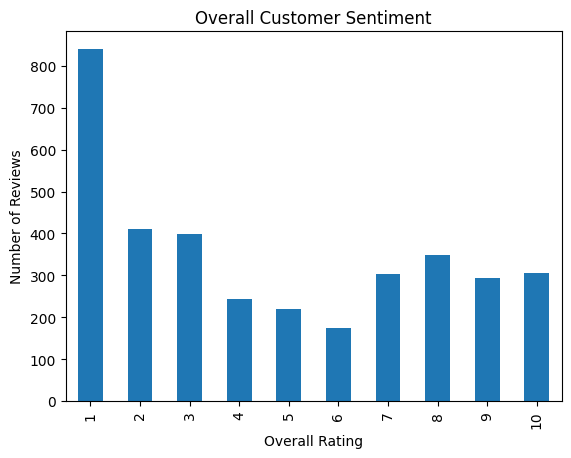

In [16]:
'''Overall Customer Sentiment:'''


# Filter out rows where 'overall rating' is 0
df = df[df['overall rating'] != 0]

overall_sentiment_distribution = df['overall rating'].value_counts().sort_index()
overall_sentiment_distribution.plot(kind='bar', xlabel='Overall Rating', ylabel='Number of Reviews', title='Overall Customer Sentiment')
plt.show()

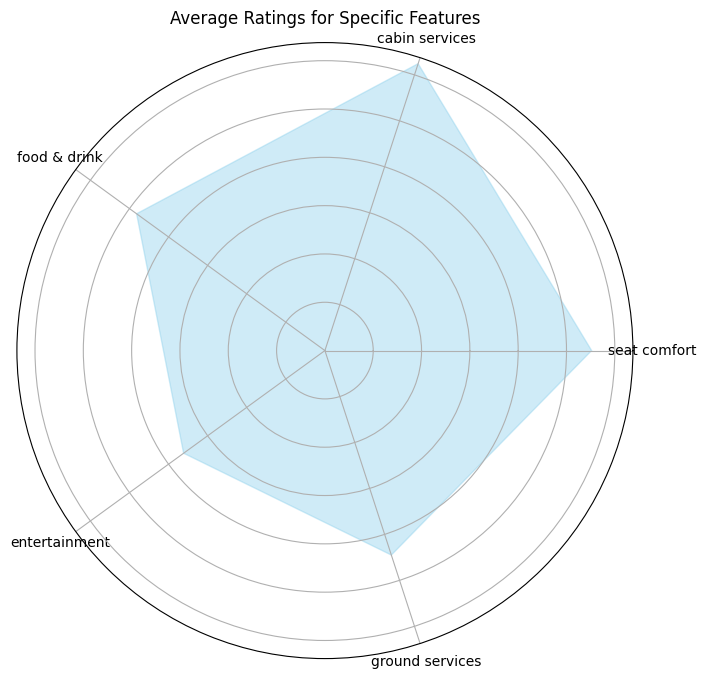

In [17]:
# Define features for radar plot
features = ['seat comfort', 'cabin services', 'food & drink', 'entertainment', 'ground services']


average_ratings = df[features].mean()

# Number of features
num_features = len(features)

# Create a radar plot
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]

# Ensure both angles and average_ratings have the same number of elements
average_ratings = list(average_ratings) + [average_ratings[0]]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.fill(angles, average_ratings, color='skyblue', alpha=0.4)
ax.set_yticklabels([])
ax.set_thetagrids(np.degrees(angles[:-1]), features)

plt.title('Average Ratings for Specific Features')
plt.show()


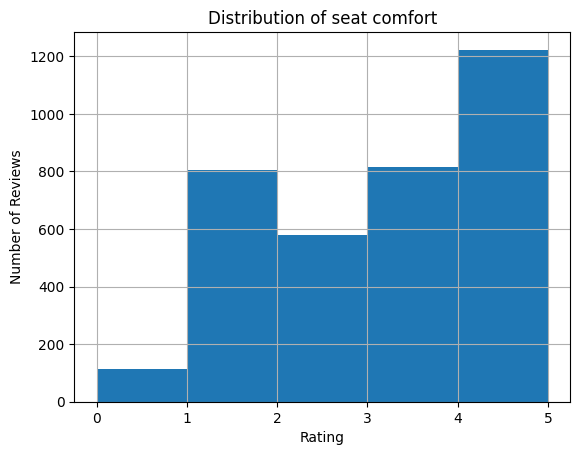

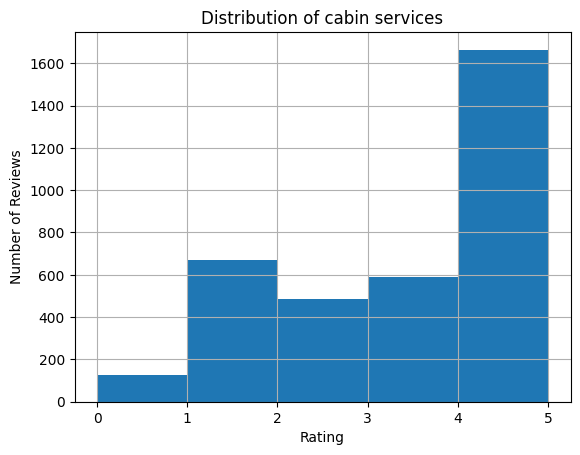

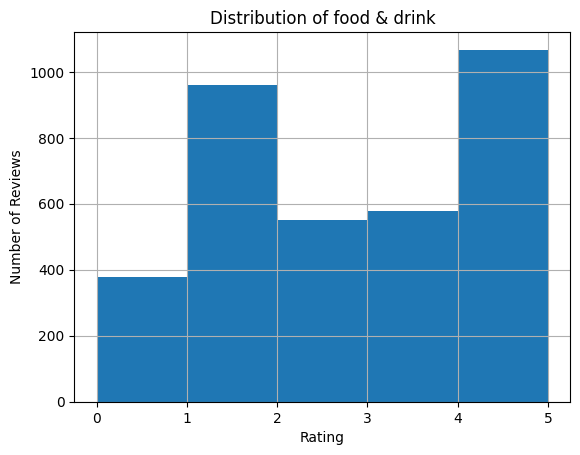

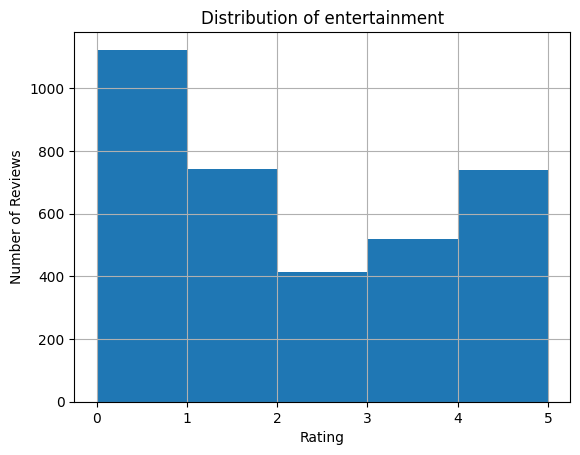

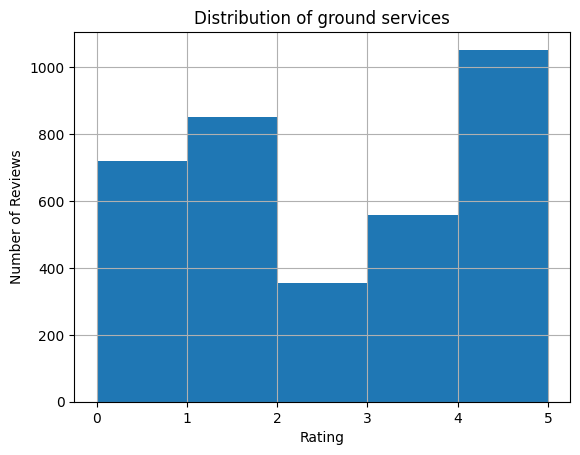

In [18]:
'''Feature-wise Analysis:'''

features = ['seat comfort', 'cabin services', 'food & drink', 'entertainment', 'ground services']
for feature in features:
    df[feature].hist(bins=5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.show()

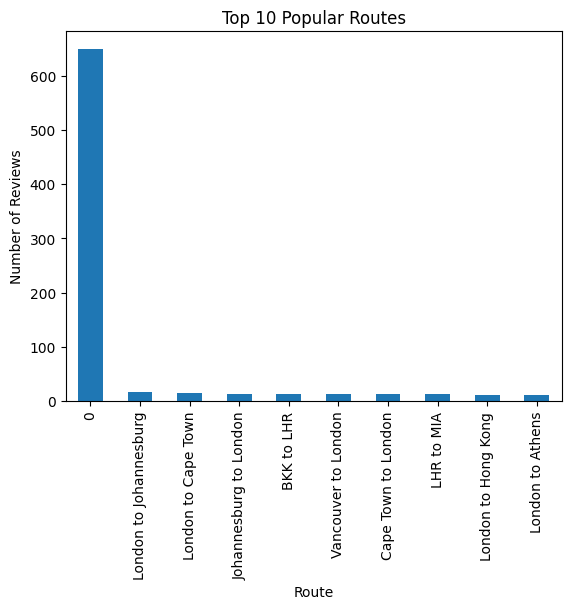

In [19]:
'''Route and Aircraft Preferences:'''

popular_routes = df['route'].value_counts().head(10)
popular_routes.plot(kind='bar', xlabel='Route', ylabel='Number of Reviews', title='Top 10 Popular Routes')
plt.show()

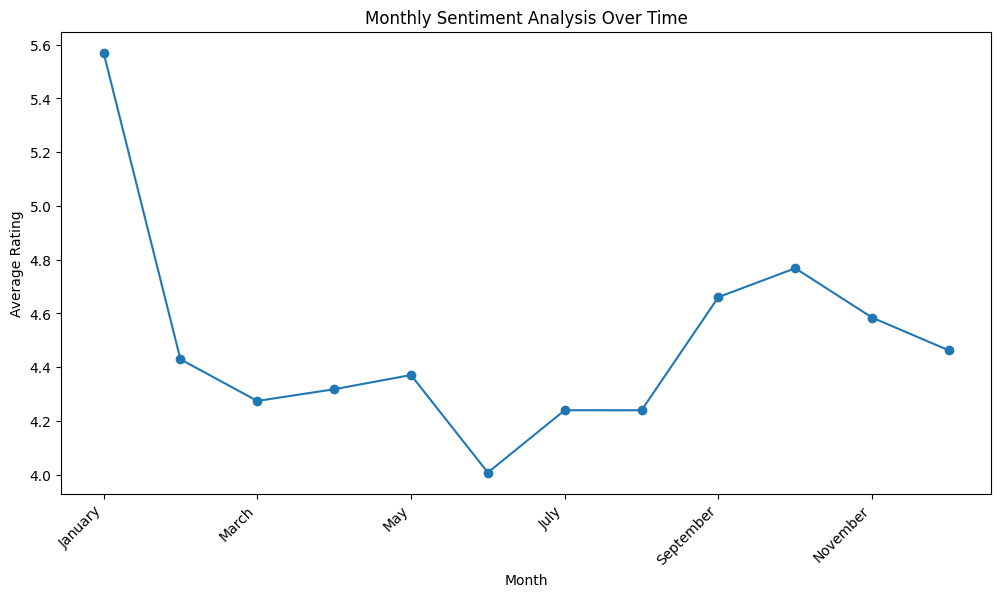

In [20]:
# Convert 'date flown' to datetime
df['date flown'] = pd.to_datetime(df['date flown'])

# Extract full month names
df['month'] = df['date flown'].dt.strftime('%B')

# Order months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

# Group by month and calculate average overall rating
monthly_sentiment = df.groupby('month')['overall rating'].mean()

# Reindex to include all months
monthly_sentiment = monthly_sentiment.reindex(month_order)

# Plot monthly sentiment analysis with full month names
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(marker='o', xlabel='Month', ylabel='Average Rating', title='Monthly Sentiment Analysis Over Time')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


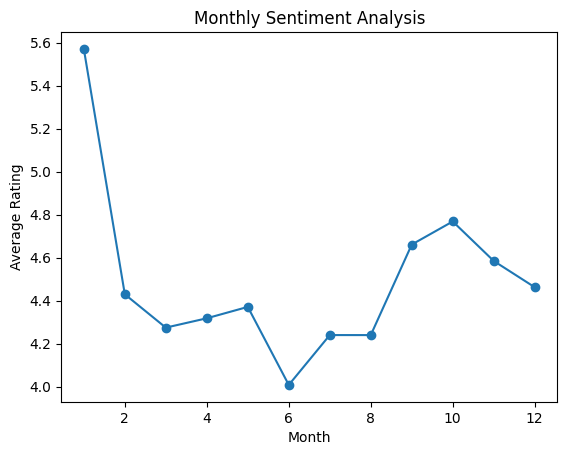

In [21]:
'''Temporal Analysis:'''

df['date flown'] = pd.to_datetime(df['date flown'])
df['month'] = df['date flown'].dt.month
monthly_sentiment = df.groupby('month')['overall rating'].mean()
monthly_sentiment.plot(marker='o', xlabel='Month', ylabel='Average Rating', title='Monthly Sentiment Analysis')
plt.show()

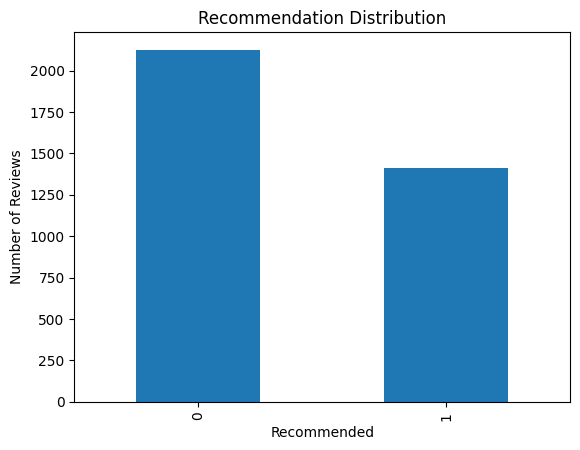

recommended
0    2125
1    1411
Name: count, dtype: int64


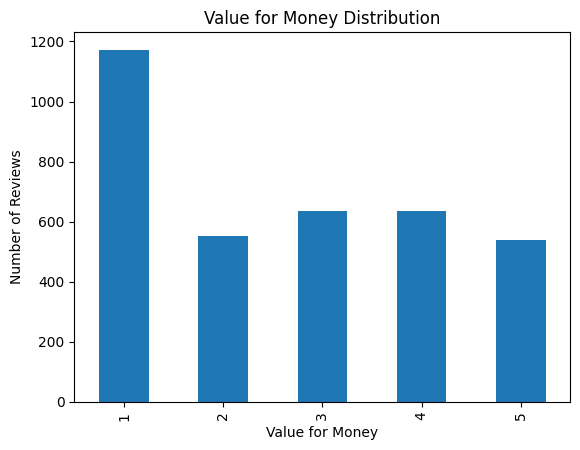

value_money
1    1172
3     637
4     636
2     553
5     538
Name: count, dtype: int64


In [22]:
'''Recommended and Value for Money:'''
recommendation_distribution = df['recommended'].value_counts().sort_index()
recommendation_distribution.plot(kind='bar', xlabel='Recommended', ylabel='Number of Reviews', title='Recommendation Distribution')
plt.show()

rec_count = df['recommended'].value_counts()
print(rec_count)

value_for_money_distribution = df['value_money'].value_counts().sort_index()
value_for_money_distribution.plot(kind='bar', xlabel='Value for Money', ylabel='Number of Reviews', title='Value for Money Distribution')
plt.show()


vm_count = df['value_money'].value_counts()
print(vm_count)

In [23]:
'''sentiment Analysis'''



# relevants columns are selected for sentiment analysis
df_sentiment = df[['reviewer', 'comment head', 'comment body', 'overall rating']]

reviews = df_sentiment['comment body']


# using the pre-trained sentiment analyzer
sia = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    score = sia.polarity_scores(text)
    return score["compound"]

df_sentiment["sentiment_score"] = reviews.apply(get_sentiment_score)
df_sentiment.head()

,reviewer,comment head,comment body,overall rating,sentiment_score
0,A Dawson,"""It is a national disgrace""",I take comfort in reading the last ten or so ...,1,-0.7424
1,Massimo Garavaglia,"""The worst journey in my life""",The worst journey in my life. The connection ...,3,-0.9299
2,Tom Slowbe,"""Very disappointed""","The airplanes and the lounges are worn out, ol...",4,-0.8899
3,E Anderson,"""the service was shockingly bad""",One of the worst experiences on the worst airl...,1,-0.9830
4,C Horden,"""Never again will I fly BA""",Cancelled our flight last-minute then moved u...,1,0.6833


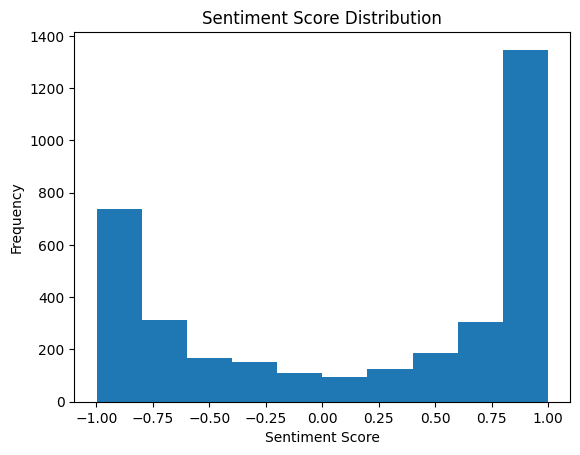

In [24]:

# visual distribution of sentiment scores in a histogram
plt.hist(df_sentiment["sentiment_score"])
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

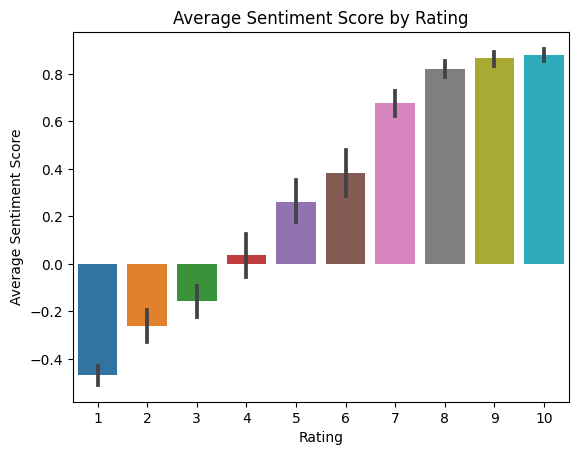

In [25]:

'''bar plot of the average sentiment score for each rating category'''

'''the overall rating should skew towards the direction of the sentiment score.
if the rating is high, the sentiment score should also be high and vice versa'''

# Filter out rows where 'overall rating' is 0
df_sentiment_filtered = df_sentiment[df_sentiment['overall rating'] != 0]

# Create the bar plot
ax = sns.barplot(x="overall rating", y="sentiment_score", data=df_sentiment_filtered)
ax.set_title("Average Sentiment Score by Rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Average Sentiment Score")
plt.show()

In [26]:
# categorizing the sentiment as "negative", "neutral", or "positive" based on the value of the score
def map_sentiment(score):
    if score < 0:
        return 'negative'
    elif 0 <= score < 0.7:
        return 'neutral'
    else:
        return 'positive'

df_sentiment['sentiment_category'] = df_sentiment['sentiment_score'].apply(map_sentiment)

df_sentiment.head()


,reviewer,comment head,comment body,overall rating,sentiment_score,sentiment_category
0,A Dawson,"""It is a national disgrace""",I take comfort in reading the last ten or so ...,1,-0.7424,negative
1,Massimo Garavaglia,"""The worst journey in my life""",The worst journey in my life. The connection ...,3,-0.9299,negative
2,Tom Slowbe,"""Very disappointed""","The airplanes and the lounges are worn out, ol...",4,-0.8899,negative
3,E Anderson,"""the service was shockingly bad""",One of the worst experiences on the worst airl...,1,-0.9830,negative
4,C Horden,"""Never again will I fly BA""",Cancelled our flight last-minute then moved u...,1,0.6833,neutral


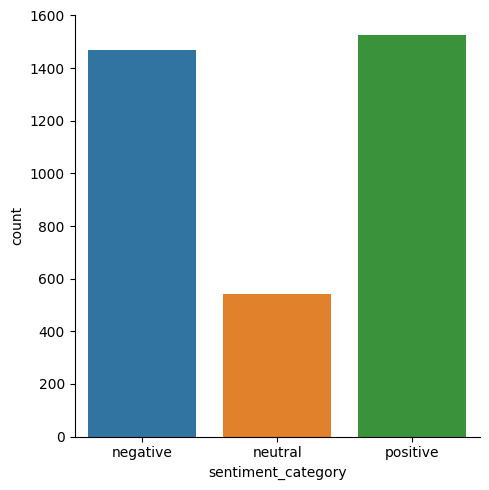

In [27]:
'''to get a clearer picture of the customer sentiment, they are grouped
according to their sentiment score. They are in 3 distinct groups of
positive, neutral and negative. The catplot below is a graphical
representation of the result.'''


sns.catplot(x='sentiment_category', kind='count', data=df_sentiment)

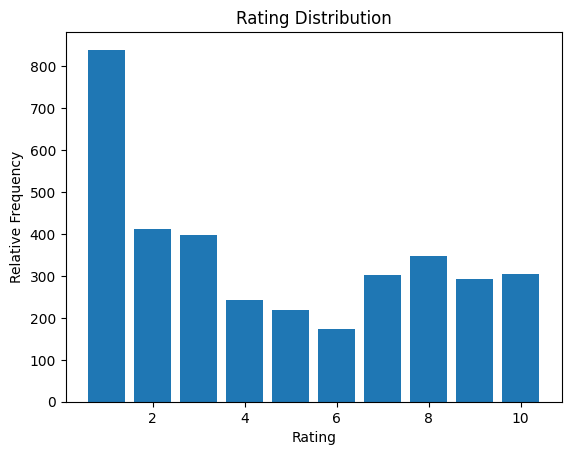

,reviewer,comment head,comment body,overall rating,sentiment_score,sentiment_category
0,A Dawson,"""It is a national disgrace""",I take comfort in reading the last ten or so ...,1,-0.7424,negative
1,Massimo Garavaglia,"""The worst journey in my life""",The worst journey in my life. The connection ...,3,-0.9299,negative
2,Tom Slowbe,"""Very disappointed""","The airplanes and the lounges are worn out, ol...",4,-0.8899,negative
3,E Anderson,"""the service was shockingly bad""",One of the worst experiences on the worst airl...,1,-0.9830,negative
4,C Horden,"""Never again will I fly BA""",Cancelled our flight last-minute then moved u...,1,0.6833,neutral


In [28]:
# number of occurrences of each rating value

df_s = df[df['overall rating'] != 0]
rating_distribution = df_s['overall rating'].value_counts()

plt.bar(rating_distribution.index, rating_distribution.values)
plt.xlabel('Rating')
plt.ylabel('Relative Frequency')
plt.title('Rating Distribution')
plt.show()


# relevants columns are selected for sentiment analysis
df_sentiment.head()

In [29]:
# Count the occurrences of each sentiment category
sentiment_counts = df_sentiment['sentiment_category'].value_counts()

sentiment_counts

sentiment_category
positive    1525
negative    1470
neutral      541
Name: count, dtype: int64

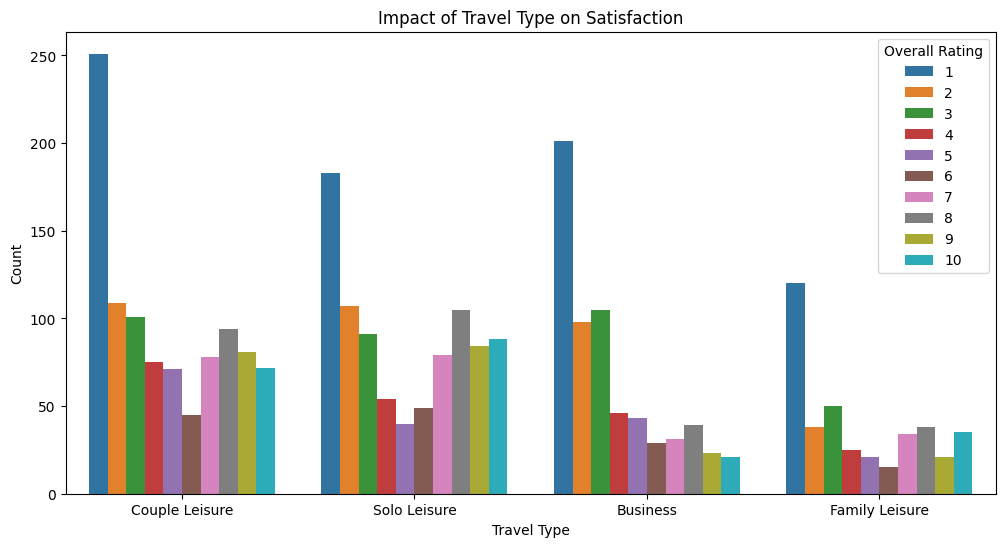

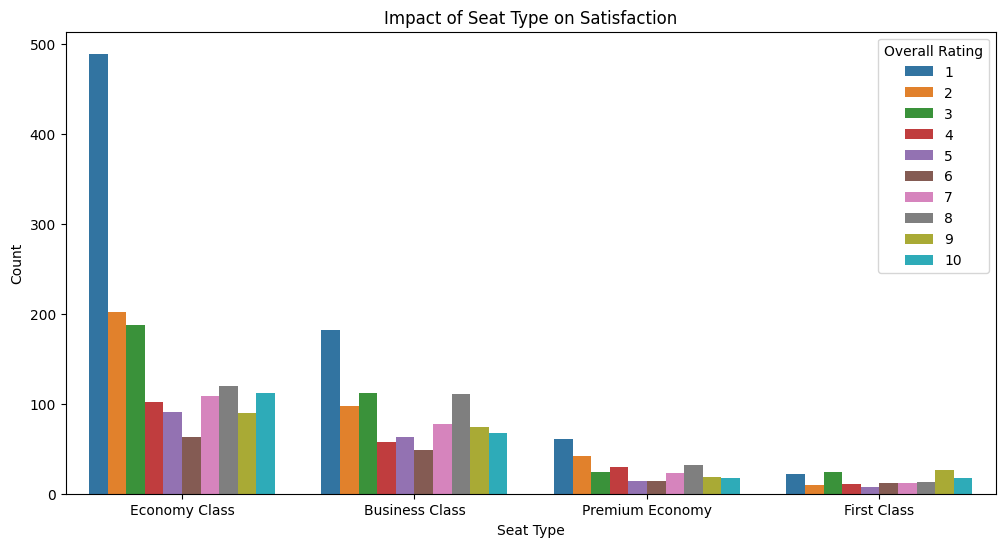

In [ ]:
'''Segmentation:'''

# Segment by Travel Type
df = df[df['travel type'] != 0]
plt.figure(figsize=(12, 6))
sns.countplot(x='travel type', hue='overall rating', data=df)
plt.title('Impact of Travel Type on Satisfaction')
plt.xlabel('Travel Type')
plt.ylabel('Count')
plt.legend(title='Overall Rating')
plt.show()

# Segment by Seat Type

df = df[df['seat type'] != 0]
plt.figure(figsize=(12, 6))
sns.countplot(x='seat type', hue='overall rating', data=df)
plt.title('Impact of Seat Type on Satisfaction')
plt.xlabel('Seat Type')
plt.ylabel('Count')
plt.legend(title='Overall Rating')
plt.show()


C:\Users\tunmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


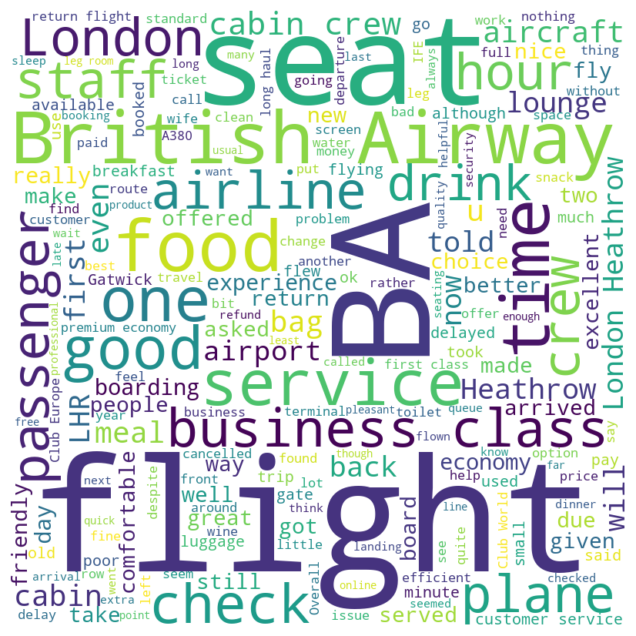

In [ ]:

'''wordcloud image. Stop words are removed using NLTK library.'''

stop_words = set(stopwords.words('english'))

reviews = [word for word in df['comment body'] if word not in stop_words]

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(reviews))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Regression analysis is used here to determine the relationship between the independent variables and the dependent variable. It can help identify the extent to which each independent variable affects the dependent variable and determine which independent variable has the most significant impact on the dependent variable.
This information can be useful for the improvement of customer satisfaction by focusing on areas that have the most significant impact on the overall rating given by the customers.

In [ ]:

df_merged = pd.merge(df, df_sentiment, how='left', on='reviewer').drop_duplicates(subset=['reviewer'])

df_merged.columns


Index(['reviewer', 'overall rating_x', 'comment head_x', 'comment body_x',
       'aircraft', 'travel type', 'seat type', 'route', 'date flown',
       'seat comfort', 'cabin services', 'food & drink', 'entertainment',
       'ground services', 'value_money', 'recommended', 'month',
       'overall rating_y', 'comment head_y', 'comment body_y',
       'sentiment_score', 'sentiment_category'],
      dtype='object')

In [ ]:
# Drop duplicate columns from df_sentiment
df_merged.drop(columns=['overall rating_y', 'comment head_y', 'comment body_y'], inplace=True)


df_merged.rename(columns={'overall rating_x': 'overall rating', 'comment head_x': 'comment head', 'comment body_x': 'comment body'}, inplace=True)

In [ ]:
'''identifying which factors have the most significant impact on the overall rating'''
# Multiple Regression Analysis

X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['overall rating']


# Add a constant to the independent value
X = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X).fit()
print(model.summary())





                            OLS Regression Results                            
Dep. Variable:         overall rating   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1284.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:03:27   Log-Likelihood:                -5420.9
No. Observations:                2760   AIC:                         1.085e+04
Df Residuals:                    2754   BIC:                         1.089e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9429      0.077    -

In [ ]:
'''identifying which factors have the most significant impact on recommendation'''


X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['recommended']


# Add a constant to the independent value
X = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            recommended   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     707.7
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:03:27   Log-Likelihood:                -709.15
No. Observations:                2760   AIC:                             1430.
Df Residuals:                    2754   BIC:                             1466.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3559      0.014    -

In [ ]:
probit_model = sm.Probit(y, X)
result = probit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.264832
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:            recommended   No. Observations:                 2760
Model:                         Probit   Df Residuals:                     2754
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.5859
Time:                        13:03:27   Log-Likelihood:                -730.94
converged:                       True   LL-Null:                       -1765.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.5792      0.154    -29.673      0.000      -4.882      -4.277
seat comfort  

In [ ]:

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.260335
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:                 2760
Model:                          Logit   Df Residuals:                     2754
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.5929
Time:                        13:03:27   Log-Likelihood:                -718.53
converged:                       True   LL-Null:                       -1765.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.5718      0.334    -25.638      0.000      -9.227      -7.916
seat comfort  

In [ ]:

X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['recommended']

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model = elasticnet.fit(X, y)

# Print out the coefficients of the model
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

seat comfort: 0.0811344825336501
cabin services: 0.05482790153913072
food & drink: 0.08780780636447455
entertainment: 0.0
ground services: 0.014068530268960348


In [ ]:
'''identifying which factors have the most significant impact on value_money'''



X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['value_money']


# Add a constant to the independent value
X = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X).fit()
print(model.summary())





                            OLS Regression Results                            
Dep. Variable:            value_money   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     874.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:03:27   Log-Likelihood:                -3646.5
No. Observations:                2760   AIC:                             7305.
Df Residuals:                    2754   BIC:                             7341.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2537      0.041     

In [ ]:
'''identifying which factors have the most significant impact on sentiment score'''



X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['sentiment_score']


# Add a constant to the independent value
X = sm.add_constant(X)

# Perform regression analysis
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     287.4
Date:                Sat, 30 Sep 2023   Prob (F-statistic):          5.84e-248
Time:                        13:03:27   Log-Likelihood:                -2659.3
No. Observations:                2760   AIC:                             5331.
Df Residuals:                    2754   BIC:                             5366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8406      0.028    -

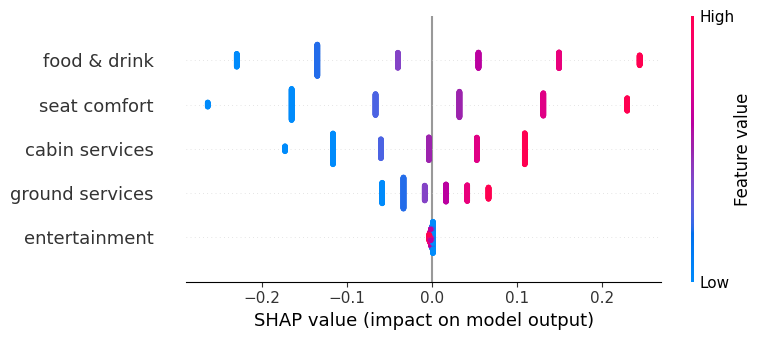

In [ ]:


X = df_merged[['seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services']]
y = df_merged['recommended']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
regression_model = LinearRegression()

# Train the model
regression_model.fit(X_train, y_train)

# Create a SHAP explainer using the KernelExplainer
explainer = shap.Explainer(regression_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test)


### Build a predictive model to understand factors that influence buying behaviour

In [ ]:
'''feature selection done to include both the sentiment score and the sentiment category'''

df_2 = df_merged[['reviewer', 'overall rating', 'sentiment_score', 'seat comfort', 'cabin services', 'food & drink',
       'entertainment', 'ground services', 'value_money', 'recommended']]

df_2.head()

,reviewer,overall rating,sentiment_score,seat comfort,cabin services,food & drink,entertainment,ground services,value_money,recommended
0,Massimo Garavaglia,3,-0.9299,3,3,2,4,1,1,0
1,Tom Slowbe,4,-0.8899,1,4,4,3,3,2,0
2,E Anderson,1,-0.9830,2,1,1,0,1,1,0
3,C Horden,1,0.6833,1,1,1,3,2,1,0
4,P Cooper,1,-0.8689,1,3,2,1,1,1,0


In [ ]:
# Split into train (80%), and test (10%)
df_train, df_test = train_test_split(df_2, test_size=0.2, random_state=42)

# Print the shapes of the sets
print("Train set:", df_train.shape)

print("Test set:", df_test.shape)

Train set: (2208, 10)
Test set: (552, 10)


In [ ]:
'''model building using Random Forest Classifier'''



# Select features and target
X = df_train.drop(columns=['reviewer', 'recommended'])
y = df_train['recommended']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')



Accuracy: 0.9389140271493213


In [ ]:

X_test = df_test.drop(columns=['reviewer', 'recommended'])
y_test = df_test['recommended']

# Make predictions on test data
y_pred = model.predict(X_test)

# Create a DataFrame with reviewer, actual and predicted values
df_results = pd.DataFrame({'Reviewer': df_test['reviewer'], 'Actual': y_test, 'Predicted': y_pred})

df_results.head(10)


,Reviewer,Actual,Predicted
1185,G Thanidhar,0,0
5108,M Williams,1,0
8032,J Reed,1,1
8959,Lucas Robert,0,0
1940,Matt Barrick,1,1
3184,Wayne Mckay,0,0
871,Rolf Linden,0,0
6185,Sheila Gale,0,0
1180,Thomas Scrivens,0,0
9756,I Lancaster,1,1


[[356  11]
 [  7 178]]


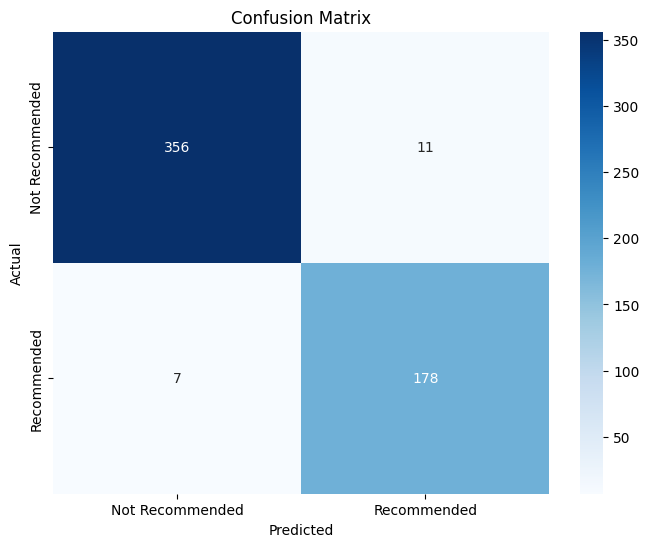

In [ ]:


conf_matrix = confusion_matrix(df_results['Actual'], df_results['Predicted'])
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
